Using file: /content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv
Data rows: 610
['Feed Rate /Flute (mm/flute)', 'Feed Rate', 'Depth Of Cut (mm)', 'Spindle Speed', 'Time (Sec)', 'P (w)']
Physics proxy sample (W): [0.57645   4.1135178 1.9297283 2.4681106 1.1529   ]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

ANN test metrics -> MSE: 7029.549, MAE: 59.206, R2: 0.9442
Epoch 1/300 -> data_loss=0.564274, phys_loss=2.771435, total=0.619703, lam=0.02000
Epoch 25/300 -> data_loss=0.284055, phys_loss=3.008888, total=0.344233, lam=0.02000
Epoch 50/300 -> data_loss=0.246917, phys_loss=3.014202, total=0.307202, lam=0.01400
Epoch 75/300 -> data_loss=0.212429, phys_loss=2.966760, total=0.253964, lam=0.01400
Epoch 100/300 -> data_loss=0.209384, phys_loss=3.136421, total=0.253294, lam=0.00980
Epoch 125/300 -> data_loss=0.195366, phys_loss=2.916176, total=0.223944, lam=0.00980
Epoch 150/300 -> data_loss=0.185706, phys_loss=2.981170, total=0.214921, lam=0.00686
Epoch 175/300 -> data_loss=0.170278, p

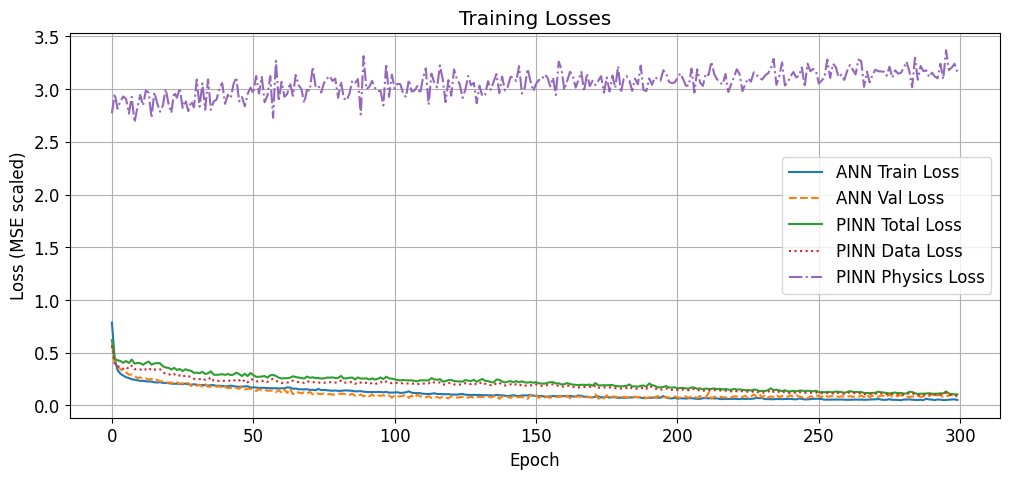

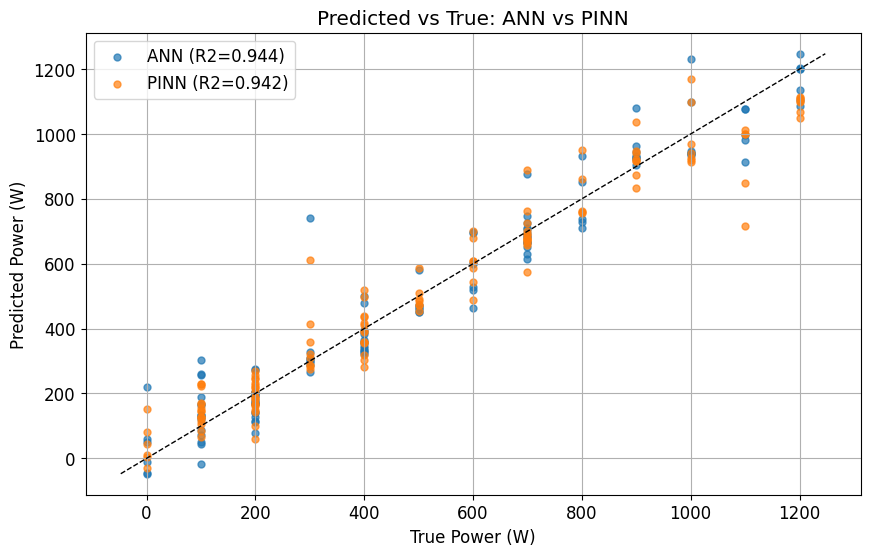

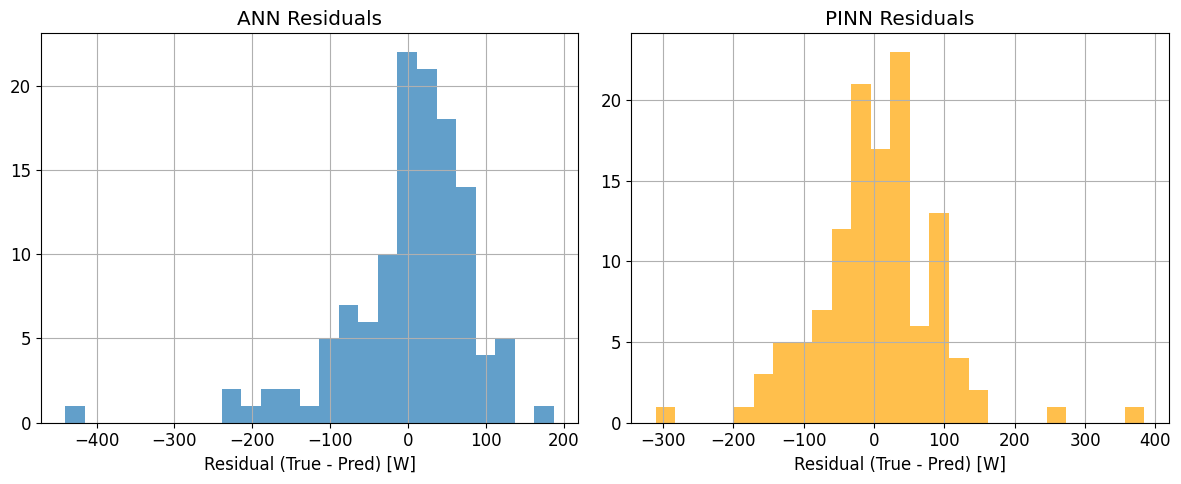

/tmp/ipython-input-2479135188.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([abs_ann, abs_pinn], labels=['ANN', 'PINN'])


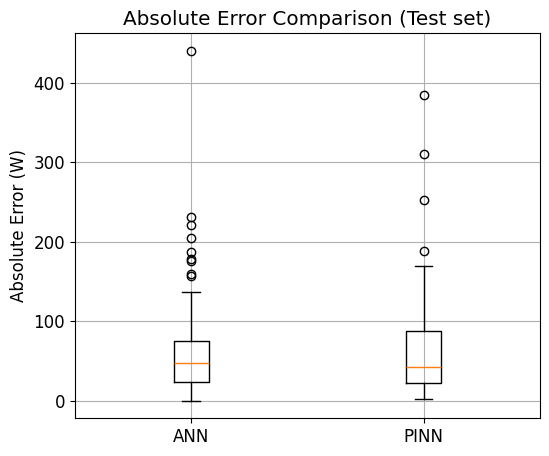

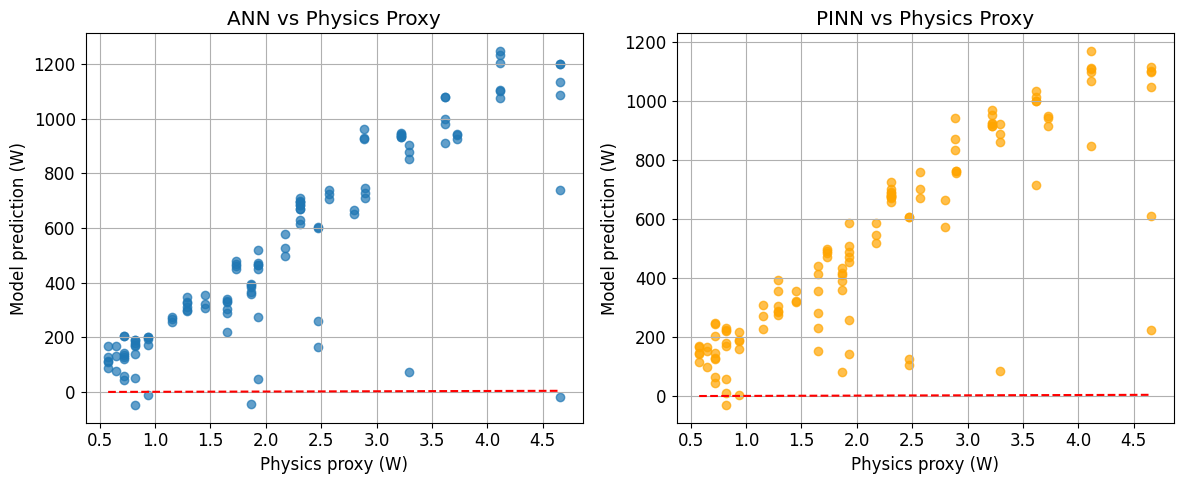

In [ ]:
# Full script: ANN vs PINN
# Uses K_tc=2517.58, K_te=18.9, r=5.0 (mm), phi_j=35 degrees
# =========================

# 0) Install (uncomment in Colab if needed)
# !pip install --upgrade pip
# !pip install chardet xgboost --quiet

# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# 2) Load data - change path if required
# If the file is in Colab drive use that path instead
file_path = "/mnt/data/Gear_training.csv"   # or "/content/drive/MyDrive/..." if using Drive
if not os.path.exists(file_path):
    # fallback: try common drive path (uncomment if needed)
    file_path = "/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv"

print("Using file:", file_path)
df = pd.read_csv(file_path, encoding="ISO-8859-1")
print("Data rows:", len(df))
print(df.columns.tolist())

# 3) Prepare features / target
# The table you showed uses Feed per flute = 0.1 mm/flute; but dataset columns may be 'Feed Rate' etc.
# We use these columns (adjust if your CSV column names differ)
feature_cols = ["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]
for c in feature_cols + ["P (w)"]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in CSV. Found columns: {df.columns.tolist()}")

X = df[feature_cols].astype(float).values      # [Fs, a(mm), Ns, T]
y = df["P (w)"].astype(float).values.reshape(-1,1)

# 4) Train-test split + scalers
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

X_train = scaler_X.transform(X_train_raw).astype(np.float32)
X_test = scaler_X.transform(X_test_raw).astype(np.float32)
y_train = scaler_y.transform(y_train_raw).astype(np.float32)
y_test = scaler_y.transform(y_test_raw).astype(np.float32)

# Convert to TF tensors for PINN training
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

# 5) Physics constants (from you)
K_tc = 2517.58   # as provided
K_te = 18.9
r_mm = 5.0       # mm
r_m = r_mm / 1000.0  # convert to meters
phi_deg = 35.0
phi_j = np.deg2rad(phi_deg)

# Physics function using raw (unscaled) inputs (X_raw rows)
def physics_power_from_raw(X_raw_rows):
    """
    X_raw_rows: numpy array shape (n,4)
      columns: [Feed Rate (mm/flute or mm/min?), Depth Of Cut (mm), Spindle Speed (rpm), Time (sec)]
    Returns: P_phys (n,1) in Watts (using consistent units: m, N, rad/s)
    """
    # Interpret column order:
    # Feed per flute (Fs) in mm (user uses Feed Rate column as Fs)
    Fs_mm = X_raw_rows[:, 0].astype(np.float64)
    a_mm = X_raw_rows[:, 1].astype(np.float64)        # depth of cut (mm)
    Ns = X_raw_rows[:, 2].astype(np.float64)          # spindle speed (rpm)

    # convert mm to m where needed
    a_m = a_mm / 1000.0
    Fs_m = Fs_mm / 1000.0

    # chip thickness
    h_phi = Fs_m * np.sin(phi_j)   # m

    # Ft = Ktc * a * h + Kte * a
    # Here K_tc is applied assuming units consistent with a_m and h_phi -> choose K_tc in N/m^2
    Ft = K_tc * a_m * h_phi + K_te * a_m   # N

    # torque tau_s = r * Ft (use r_m in meters)
    tau_s = r_m * Ft   # N·m

    # angular speed
    omega = 2.0 * np.pi * Ns / 60.0  # rad/s

    # spindle power
    P_phy = (tau_s * omega).reshape(-1,1)   # Watts

    return P_phy.astype(np.float32)

# Quick physics sanity check (first 5 train rows)
P_phy_sample = physics_power_from_raw(X_train_raw[:5])
print("Physics proxy sample (W):", P_phy_sample.flatten()[:5])

# 6) Build ANN (data-only)
def build_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

# 7) Build PINN model (same base architecture, tanh activations)
def build_pinn(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(1)
    ])
    return model

# 8) Train ANN for same epochs (300)
EPOCHS = 300
BATCH = 32

ann = build_ann(X_train.shape[1])
history_ann = ann.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=0)

# ANN predictions (unscaled)
yhat_ann_scaled = ann.predict(X_test)
yhat_ann = scaler_y.inverse_transform(yhat_ann_scaled)

mse_ann = mean_squared_error(y_test_raw, yhat_ann)
mae_ann = mean_absolute_error(y_test_raw, yhat_ann)
r2_ann = r2_score(y_test_raw, yhat_ann)
print("\nANN test metrics -> MSE: %.3f, MAE: %.3f, R2: %.4f" % (mse_ann, mae_ann, r2_ann))

# 9) Improved PINN training: use physics proxy but scale it to target's scaler_y scale
def train_pinn_with_physics(model, X_train_scaled, X_train_raw, y_train_scaled,
                            lambda_phys=0.02, epochs=EPOCHS, batch_size=BATCH,
                            adaptive_lambda=True, verbose=True):
    """
    model: keras model (uncompiled)
    X_train_scaled: scaled inputs (np.array)
    X_train_raw: raw inputs in original units (np.array) (used for physics)
    y_train_scaled: scaled targets (np.array)
    """
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}
    lam = lambda_phys

    for epoch in range(epochs):
        epoch_data_losses = []
        epoch_phys_losses = []
        epoch_total_losses = []

        for x_scaled_batch, x_raw_batch, y_batch in dataset:
            # x_scaled_batch: scaled inputs (for model). x_raw_batch: raw physical units (for physics)
            with tf.GradientTape() as tape:
                y_pred_scaled = model(x_scaled_batch, training=True)   # predicted in scaled target space

                # data loss (on scaled targets)
                data_loss = mse(y_batch, y_pred_scaled)

                # physics prediction from raw inputs -> returns Watts, we must scale to y-scale
                x_raw_np = x_raw_batch.numpy()
                P_phy = physics_power_from_raw(x_raw_np)              # shape (b,1), in Watts (raw)
                # scale physics proxy to target scaled space
                P_phy_scaled = scaler_y.transform(P_phy)              # numpy array
                P_phy_scaled_tf = tf.convert_to_tensor(P_phy_scaled, dtype=tf.float32)

                # physics loss (on scaled space)
                phys_loss = tf.reduce_mean(tf.square(y_pred_scaled - P_phy_scaled_tf))

                total_loss = data_loss + lam * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_losses.append(data_loss.numpy())
            epoch_phys_losses.append(phys_loss.numpy())
            epoch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_losses))
        history["phys_loss"].append(np.mean(epoch_phys_losses))
        history["total_loss"].append(np.mean(epoch_total_losses))

        # adaptive lambda to avoid physics dominating early or late
        if adaptive_lambda and ((epoch+1) % 50 == 0):
            lam *= 0.7

        if verbose and ((epoch+1) % 25 == 0 or epoch==0 or epoch==epochs-1):
            print(f"Epoch {epoch+1}/{epochs} -> data_loss={history['data_loss'][-1]:.6f}, "
                  f"phys_loss={history['phys_loss'][-1]:.6f}, total={history['total_loss'][-1]:.6f}, lam={lam:.5f}")

    return model, history

# instantiate PINN
pinn = build_pinn(X_train.shape[1])
pinn, history_pinn = train_pinn_with_physics(pinn, X_train, X_train_raw, y_train,
                                             lambda_phys=0.02, epochs=EPOCHS, batch_size=BATCH,
                                             adaptive_lambda=True, verbose=True)

# 10) PINN predictions (reverse scaling)
yhat_pinn_scaled = pinn.predict(X_test)
yhat_pinn = scaler_y.inverse_transform(yhat_pinn_scaled)

mse_pinn = mean_squared_error(y_test_raw, yhat_pinn)
mae_pinn = mean_absolute_error(y_test_raw, yhat_pinn)
r2_pinn = r2_score(y_test_raw, yhat_pinn)
print("\nPINN test metrics -> MSE: %.3f, MAE: %.3f, R2: %.4f" % (mse_pinn, mae_pinn, r2_pinn))

# 11) Plots: loss curves, pred vs true, residuals, physics-consistency, extrapolation test
plt.rcParams.update({'font.size':12})

# Loss curves (ANN training loss + PINN three losses)
plt.figure(figsize=(12,5))
plt.plot(history_ann.history['loss'], label='ANN Train Loss')
if 'val_loss' in history_ann.history:
    plt.plot(history_ann.history['val_loss'], label='ANN Val Loss', linestyle='--')
plt.plot(history_pinn['total_loss'], label='PINN Total Loss')
plt.plot(history_pinn['data_loss'], label='PINN Data Loss', linestyle=':')
plt.plot(history_pinn['phys_loss'], label='PINN Physics Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss (MSE scaled)'); plt.title('Training Losses'); plt.legend(); plt.grid()
plt.show()

# Predictions vs True
plt.figure(figsize=(10,6))
plt.scatter(y_test_raw, yhat_ann, label=f'ANN (R2={r2_ann:.3f})', alpha=0.7, s=25)
plt.scatter(y_test_raw, yhat_pinn, label=f'PINN (R2={r2_pinn:.3f})', alpha=0.7, s=25)
mn = min(y_test_raw.min(), yhat_ann.min(), yhat_pinn.min()); mx = max(y_test_raw.max(), yhat_ann.max(), yhat_pinn.max())
plt.plot([mn,mx],[mn,mx],'k--', linewidth=1)
plt.xlabel('True Power (W)'); plt.ylabel('Predicted Power (W)')
plt.title('Predicted vs True: ANN vs PINN'); plt.legend(); plt.grid()
plt.show()

# Residual histograms
res_ann = (y_test_raw - yhat_ann).flatten()
res_pinn = (y_test_raw - yhat_pinn).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(res_ann, bins=25, alpha=0.7, label='ANN')
plt.xlabel('Residual (True - Pred) [W]'); plt.title('ANN Residuals'); plt.grid(True)
plt.subplot(1,2,2)
plt.hist(res_pinn, bins=25, alpha=0.7, color='orange', label='PINN')
plt.xlabel('Residual (True - Pred) [W]'); plt.title('PINN Residuals'); plt.grid(True)
plt.tight_layout(); plt.show()

# Boxplot of absolute errors
abs_ann = np.abs(res_ann); abs_pinn = np.abs(res_pinn)
plt.figure(figsize=(6,5))
plt.boxplot([abs_ann, abs_pinn], labels=['ANN', 'PINN'])
plt.ylabel('Absolute Error (W)')
plt.title('Absolute Error Comparison (Test set)')
plt.grid(True); plt.show()

# Physics-consistency scatter: model predictions vs physics proxy computed on test set raw
P_phys_test = physics_power_from_raw(X_test_raw)        # Watts
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(P_phys_test, yhat_ann, alpha=0.7, label='ANN preds')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('ANN vs Physics Proxy'); plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(P_phys_test, yhat_pinn, alpha=0.7, label='PINN preds', color='orange')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('PINN vs Physics Proxy'); plt.grid(True)
plt.tight_layout(); plt.show()

# Extrapolation test: increase spindle speed by 50% for test set and compare
X_extrap = X_test_raw.copy()
X_extrap[:,2] = X_extrap[:,2] * 1.5   # increase s*

In [ ]:
# ANN vs Soft PINN vs Hybrid PINN
# ===============================

# ✅ Required imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Keep your data loading, scalers, and physics_power_from_raw from earlier!)

# -------------------------
# ANN
# -------------------------
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model


# -------------------------
# Method 1: Soft Constraint PINN
# -------------------------
def build_pinn(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)
    ])
    return model

def train_pinn_soft(model, X_train_scaled, X_train_raw, y_train_scaled,
                    lambda_phys=0.02, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()
    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        batch_data_losses, batch_phys_losses, batch_total_losses = [], [], []

        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_scaled, training=True)
                data_loss = mse(y_true, y_pred)

                # Physics-based power calculation
                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_tf))
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            batch_data_losses.append(data_loss.numpy())
            batch_phys_losses.append(phys_loss.numpy())
            batch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(batch_data_losses))
        history["phys_loss"].append(np.mean(batch_phys_losses))
        history["total_loss"].append(np.mean(batch_total_losses))

    return model, history


# -------------------------
# Method 2: Hybrid PINN (multi-task)
# -------------------------
def build_pinn_hybrid(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="tanh")(inputs)
    x = layers.Dense(64, activation="tanh")(x)
    out_data = layers.Dense(1, name="data_output")(x)
    out_phys = layers.Dense(1, name="phys_output")(x)
    model = keras.Model(inputs=inputs, outputs=[out_data, out_phys])
    return model

def train_pinn_hybrid(model, X_train_scaled, X_train_raw, y_train_scaled, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)
    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        d_losses, p_losses, t_losses = [], [], []
        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_data, y_phys = model(x_scaled, training=True)

                data_loss = mse(y_true, y_data)

                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = mse(P_phys_tf, y_phys)

                total_loss = data_loss + 0.5 * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            d_losses.append(data_loss.numpy())
            p_losses.append(phys_loss.numpy())
            t_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(d_losses))
        history["phys_loss"].append(np.mean(p_losses))
        history["total_loss"].append(np.mean(t_losses))

    return model, history


# -------------------------
# Train Models
# -------------------------
# ANN
ann = build_ann(X_train.shape[1])
ann.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

# PINN 1 (Soft constraint)
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, hist_soft = train_pinn_soft(pinn_soft, X_train, X_train_raw, y_train, epochs=300)

# PINN 2 (Hybrid)
pinn_hybrid = build_pinn_hybrid(X_train.shape[1])
pinn_hybrid, hist_hybrid = train_pinn_hybrid(pinn_hybrid, X_train, X_train_raw, y_train, epochs=300)


# -------------------------
# Evaluate all models
# -------------------------
def evaluate_model(model, X_scaled, X_raw, y_true, type="ann"):
    if type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    yhat = scaler_y.inverse_transform(yhat_scaled)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2 = r2_score(y_true, yhat)
    return mse, mae, r2

results = {
    "ANN": evaluate_model(ann, X_test, X_test_raw, y_test_raw, "ann"),
    "PINN_Soft": evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, "soft"),
    "PINN_Hybrid": evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, "hybrid"),
}

print("\nModel Comparison (MSE, MAE, R2):")
for k, v in results.items():
    print(f"{k}: MSE={v[0]:.2f}, MAE={v[1]:.2f}, R2={v[2]:.3f}")



1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model Comparison (MSE, MAE, R2):
ANN: MSE=6846.54, MAE=61.80, R2=0.946
PINN_Soft: MSE=8534.95, MAE=69.03, R2=0.932
PINN_Hybrid: MSE=8176.08, MAE=63.48, R2=0.935


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Model Comparison (MSE, MAE, R2):
ANN:        MSE=5796.09, MAE=58.29, R2=0.954
PINN_Soft:  MSE=8364.44, MAE=64.20, R2=0.934
PINN_Hybrid: MSE=10117.82, MAE=70.10, R2=0.920


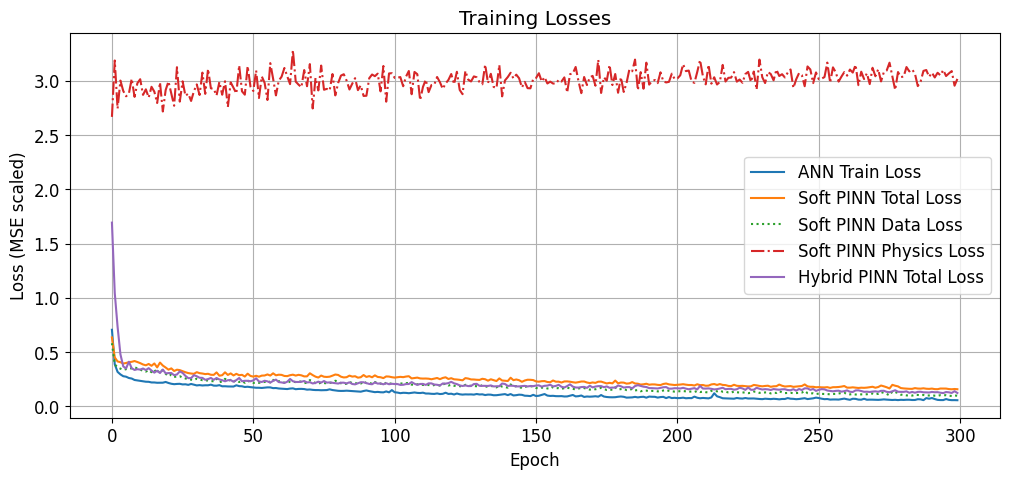

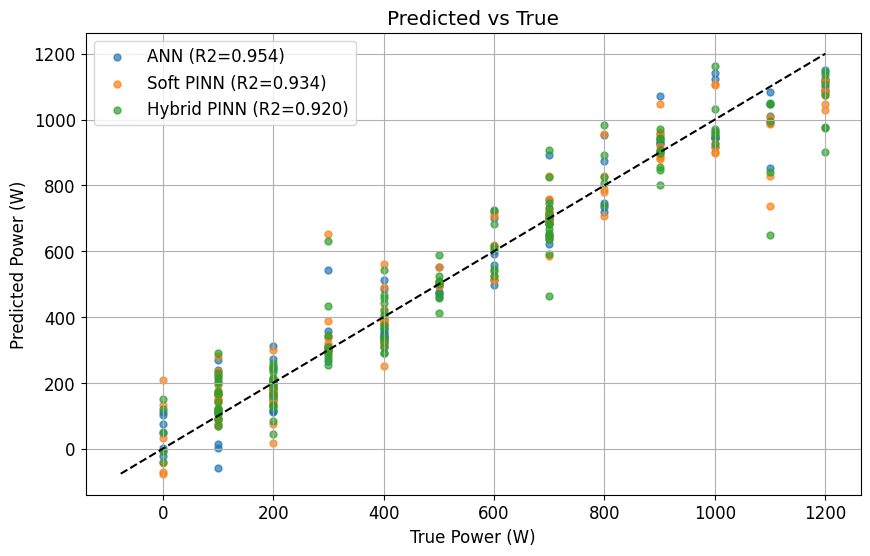

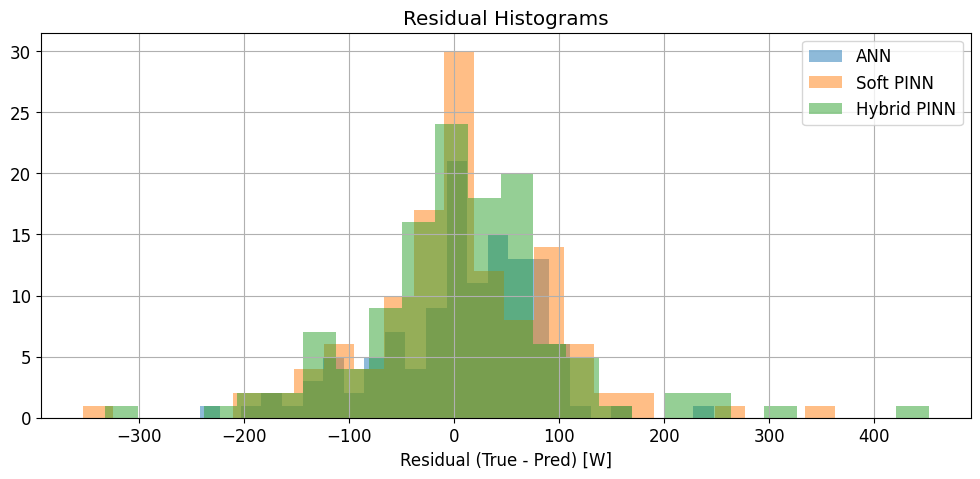

/tmp/ipython-input-3527661008.py:219: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([abs_ann, abs_soft, abs_hybrid], labels=['ANN', 'Soft PINN', 'Hybrid PINN'])


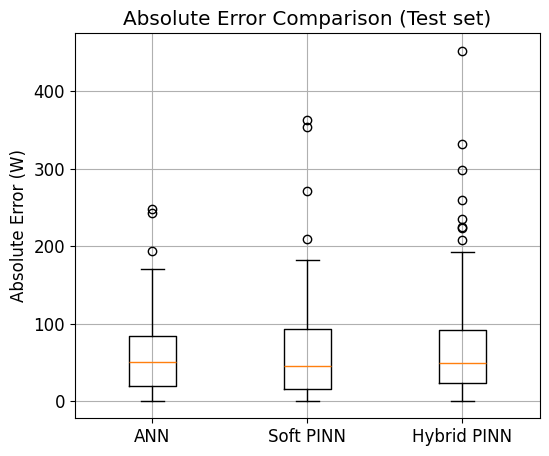

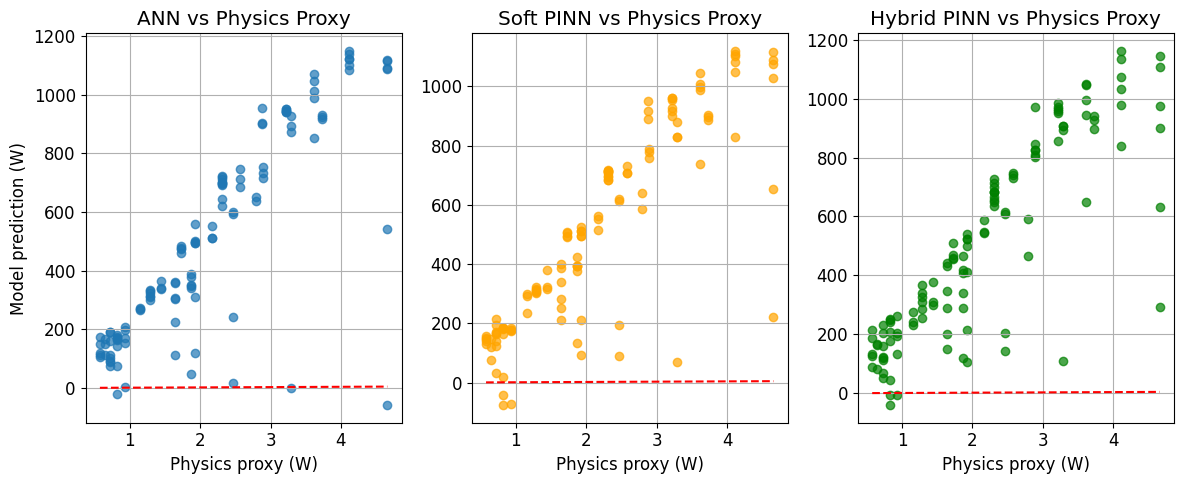

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


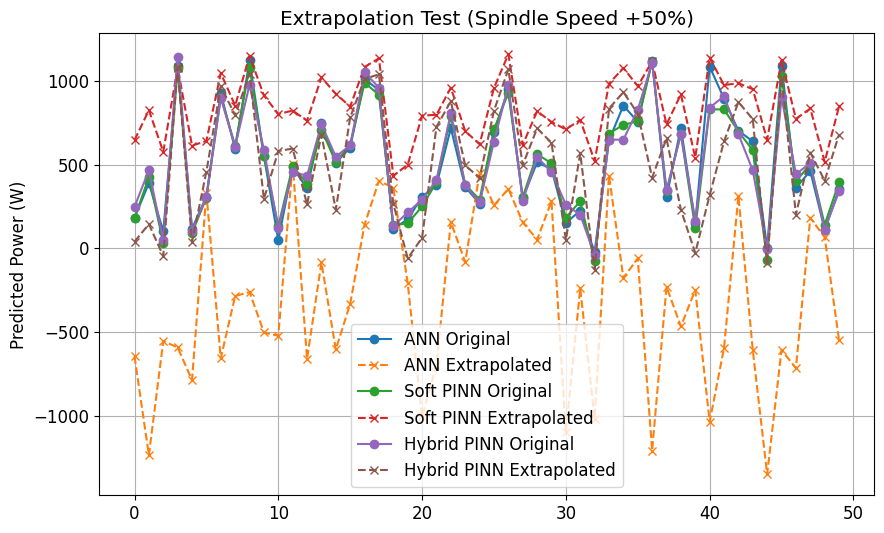

In [ ]:
# ANN vs Soft PINN vs Hybrid PINN
# ===============================

# ✅ Required imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# (Keep your data loading, scalers, and physics_power_from_raw from earlier!)

# -------------------------
# ANN
# -------------------------
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model


# -------------------------
# Method 1: Soft Constraint PINN
# -------------------------
def build_pinn(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)
    ])
    return model

def train_pinn_soft(model, X_train_scaled, X_train_raw, y_train_scaled,
                    lambda_phys=0.02, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()
    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        batch_data_losses, batch_phys_losses, batch_total_losses = [], [], []

        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_scaled, training=True)
                data_loss = mse(y_true, y_pred)

                # Physics-based power calculation
                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_tf))
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            batch_data_losses.append(data_loss.numpy())
            batch_phys_losses.append(phys_loss.numpy())
            batch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(batch_data_losses))
        history["phys_loss"].append(np.mean(batch_phys_losses))
        history["total_loss"].append(np.mean(batch_total_losses))

    return model, history


# -------------------------
# Method 2: Hybrid PINN (multi-task)
# -------------------------
def build_pinn_hybrid(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="tanh")(inputs)
    x = layers.Dense(64, activation="tanh")(x)
    out_data = layers.Dense(1, name="data_output")(x)
    out_phys = layers.Dense(1, name="phys_output")(x)
    model = keras.Model(inputs=inputs, outputs=[out_data, out_phys])
    return model

def train_pinn_hybrid(model, X_train_scaled, X_train_raw, y_train_scaled, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)
    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        d_losses, p_losses, t_losses = [], [], []
        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_data, y_phys = model(x_scaled, training=True)

                data_loss = mse(y_true, y_data)

                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = mse(P_phys_tf, y_phys)

                total_loss = data_loss + 0.5 * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            d_losses.append(data_loss.numpy())
            p_losses.append(phys_loss.numpy())
            t_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(d_losses))
        history["phys_loss"].append(np.mean(p_losses))
        history["total_loss"].append(np.mean(t_losses))

    return model, history


# -------------------------
# Train Models
# -------------------------
# ANN
ann = build_ann(X_train.shape[1])
history_ann = ann.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

# PINN 1 (Soft constraint)
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, hist_soft = train_pinn_soft(pinn_soft, X_train, X_train_raw, y_train, epochs=300)

# PINN 2 (Hybrid)
pinn_hybrid = build_pinn_hybrid(X_train.shape[1])
pinn_hybrid, hist_hybrid = train_pinn_hybrid(pinn_hybrid, X_train, X_train_raw, y_train, epochs=300)


# -------------------------
# Evaluate all models
# -------------------------
def evaluate_model(model, X_scaled, X_raw, y_true, type="ann"):
    if type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    yhat = scaler_y.inverse_transform(yhat_scaled)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2 = r2_score(y_true, yhat)
    return yhat, mse, mae, r2

yhat_ann, mse_ann, mae_ann, r2_ann = evaluate_model(ann, X_test, X_test_raw, y_test_raw, "ann")
yhat_soft, mse_soft, mae_soft, r2_soft = evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, "soft")
yhat_hybrid, mse_hybrid, mae_hybrid, r2_hybrid = evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, "hybrid")

print("\nModel Comparison (MSE, MAE, R2):")
print(f"ANN:        MSE={mse_ann:.2f}, MAE={mae_ann:.2f}, R2={r2_ann:.3f}")
print(f"PINN_Soft:  MSE={mse_soft:.2f}, MAE={mae_soft:.2f}, R2={r2_soft:.3f}")
print(f"PINN_Hybrid: MSE={mse_hybrid:.2f}, MAE={mae_hybrid:.2f}, R2={r2_hybrid:.3f}")


# -------------------------
# Visualization & Plots
# -------------------------
plt.rcParams.update({'font.size': 12})

# Loss curves
plt.figure(figsize=(12,5))
plt.plot(history_ann.history['loss'], label='ANN Train Loss')
plt.plot(hist_soft['total_loss'], label='Soft PINN Total Loss')
plt.plot(hist_soft['data_loss'], label='Soft PINN Data Loss', linestyle=':')
plt.plot(hist_soft['phys_loss'], label='Soft PINN Physics Loss', linestyle='-.')
plt.plot(hist_hybrid['total_loss'], label='Hybrid PINN Total Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss (MSE scaled)')
plt.title('Training Losses')
plt.legend(); plt.grid()
plt.show()

# Predictions vs True
plt.figure(figsize=(10,6))
plt.scatter(y_test_raw, yhat_ann, label=f'ANN (R2={r2_ann:.3f})', alpha=0.7, s=25)
plt.scatter(y_test_raw, yhat_soft, label=f'Soft PINN (R2={r2_soft:.3f})', alpha=0.7, s=25)
plt.scatter(y_test_raw, yhat_hybrid, label=f'Hybrid PINN (R2={r2_hybrid:.3f})', alpha=0.7, s=25)
mn = min(y_test_raw.min(), yhat_ann.min(), yhat_soft.min(), yhat_hybrid.min())
mx = max(y_test_raw.max(), yhat_ann.max(), yhat_soft.max(), yhat_hybrid.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('True Power (W)'); plt.ylabel('Predicted Power (W)')
plt.title('Predicted vs True')
plt.legend(); plt.grid()
plt.show()

# Residual histograms
res_ann = (y_test_raw - yhat_ann).flatten()
res_soft = (y_test_raw - yhat_soft).flatten()
res_hybrid = (y_test_raw - yhat_hybrid).flatten()

plt.figure(figsize=(12,5))
plt.hist(res_ann, bins=25, alpha=0.5, label='ANN')
plt.hist(res_soft, bins=25, alpha=0.5, label='Soft PINN')
plt.hist(res_hybrid, bins=25, alpha=0.5, label='Hybrid PINN')
plt.xlabel('Residual (True - Pred) [W]')
plt.title('Residual Histograms')
plt.legend(); plt.grid(True)
plt.show()

# Boxplot of absolute errors
abs_ann = np.abs(res_ann)
abs_soft = np.abs(res_soft)
abs_hybrid = np.abs(res_hybrid)
plt.figure(figsize=(6,5))
plt.boxplot([abs_ann, abs_soft, abs_hybrid], labels=['ANN', 'Soft PINN', 'Hybrid PINN'])
plt.ylabel('Absolute Error (W)')
plt.title('Absolute Error Comparison (Test set)')
plt.grid(True); plt.show()

# Physics-consistency scatter
P_phys_test = physics_power_from_raw(X_test_raw)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(P_phys_test, yhat_ann, alpha=0.7, label='ANN preds')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('ANN vs Physics Proxy'); plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(P_phys_test, yhat_soft, alpha=0.7, label='Soft PINN preds', color='orange')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)')
plt.title('Soft PINN vs Physics Proxy'); plt.grid(True)

plt.subplot(1,3,3)
plt.scatter(P_phys_test, yhat_hybrid, alpha=0.7, label='Hybrid PINN preds', color='green')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)')
plt.title('Hybrid PINN vs Physics Proxy'); plt.grid(True)
plt.tight_layout(); plt.show()

# Extrapolation test
X_extrap = X_test_raw.copy()
X_extrap[:, 2] = X_extrap[:, 2] * 1.5  # Increase spindle speed by 50%
X_extrap_scaled = scaler_X.transform(X_extrap)

yhat_extrap_ann = ann.predict(X_extrap_scaled)
yhat_extrap_soft = pinn_soft.predict(X_extrap_scaled)
yhat_extrap_hybrid, _ = pinn_hybrid.predict(X_extrap_scaled)

yhat_extrap_ann = scaler_y.inverse_transform(yhat_extrap_ann)
yhat_extrap_soft = scaler_y.inverse_transform(yhat_extrap_soft)
yhat_extrap_hybrid = scaler_y.inverse_transform(yhat_extrap_hybrid)

plt.figure(figsize=(10,6))
plt.plot(yhat_ann[:50], 'o-', label='ANN Original')
plt.plot(yhat_extrap_ann[:50], 'x--', label='ANN Extrapolated')
plt.plot(yhat_soft[:50], 'o-', label='Soft PINN Original')
plt.plot(yhat_extrap_soft[:50], 'x--', label='Soft PINN Extrapolated')
plt.plot(yhat_hybrid[:50], 'o-', label='Hybrid PINN Original')
plt.plot(yhat_extrap_hybrid[:50], 'x--', label='Hybrid PINN Extrapolated')
plt.ylabel('Predicted Power (W)')
plt.title('Extrapolation Test (Spindle Speed +50%)')
plt.legend(); plt.grid()
plt.show()

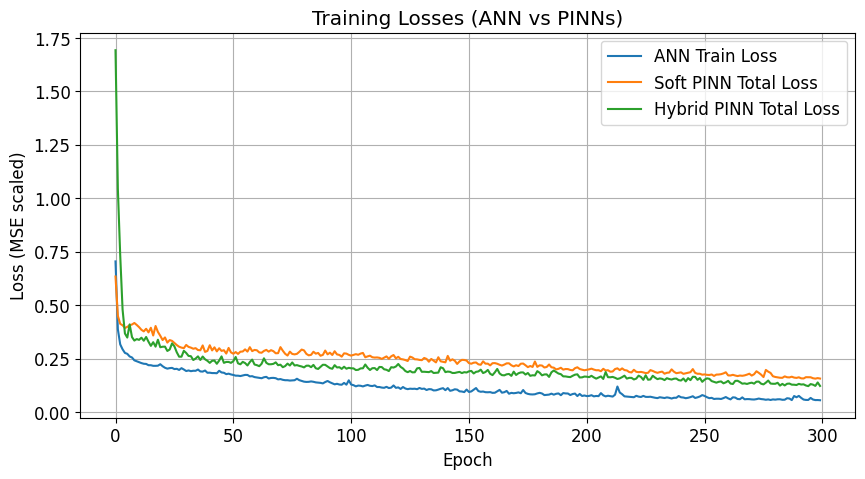

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history_ann.history['loss'], label='ANN Train Loss')
plt.plot(hist_soft['total_loss'], label='Soft PINN Total Loss')
plt.plot(hist_hybrid['total_loss'], label='Hybrid PINN Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE scaled)')
plt.title('Training Losses (ANN vs PINNs)')
plt.legend()
plt.grid(True)
plt.show()
